# Polynomial behavior

``chaospy`` relies on the package ``numpoly`` in the backend to represent all its polynomials.
It is used for the creation of polynomial expansion. like ``chaospy.orth_ttr``, and as the return object from the constructors like ``fit_regression`` and ``fit_quadrature``.

For a more extensive overview over the polynomial class, see the ``numpoly`` documentation:  https://numpoly.readthedocs.io

In [1]:
import chaospy
import numpy
import matplotlib.pyplot as plt

## Construction polynomials

A simple polynomial can be created through ``variable`` constructor. For example to construct a simple bivariate polynomial:

In [2]:
q0, q1 = chaospy.variable(dims=2)
q0

polynomial(q0)

A collection of polynomial can be manipulated using basic arithmetic operators and joined together into polynomial expansions:

In [3]:
polynomials = chaospy.polynomial([1, q0, 1-q0*q1])
polynomials

polynomial([1, q0, 1-q0*q1])

Note that constants and simple polynomials can be joined together into arrays without any problems.

In practice, having the ability to fine tune a polynomial exactly as one wants it can be useful, but it can also be cumbersome when dealing with larger arrays for application.
To automate the construction of simple polynomials, there is the ``basis`` constructor. In its simplest forms it creates an array of simple monomials:

In [4]:
chaospy.basis(4)

polynomial([1, q0, q0**2, q0**3, q0**4])

It can be expanded to include number of dimensions and a lower bound for the polynomial order:

In [5]:
chaospy.basis(start=1, stop=2, dim=2)

polynomial([q1, q0, q1**2, q0*q1, q0**2])

This tools have a lot of advanced features, like per dimension limits, and cross-truncation support. For example:

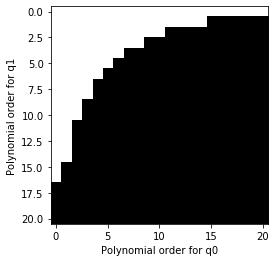

In [6]:
polynomials = chaospy.basis(start=0, stop=[16, 20], dim=2, cross_truncation=3)

grid = numpy.zeros((21, 21), dtype=int)
grid[tuple(polynomials.exponents.T)] = 1

plt.xlabel("Polynomial order for q0")
plt.ylabel("Polynomial order for q1")
plt.imshow(grid, cmap="gray")

Here we see the exponents of the polynomials plotted for both ``q0`` and ``q1``.
The white tiles indicate that the exponent pair is present.

Note that without these advanced features, the exponent grid would look as follows.

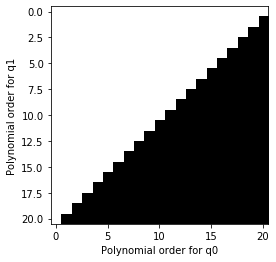

In [7]:
polynomials = chaospy.basis(start=0, stop=20, dim=2)

grid = numpy.zeros((21, 21), dtype=int)
grid[tuple(polynomials.exponents.T)] = 1

plt.xlabel("Polynomial order for q0")
plt.ylabel("Polynomial order for q1")
plt.imshow(grid, cmap="gray")

## Evaluating polynomials

As a first feature to mention, obviously these polynomials are evaluatable as functions.

In [8]:
expansion = chaospy.polynomial([1, q0**2, q0*q1])
expansion, expansion(2), expansion(q1=3)

(polynomial([1, q0**2, q0*q1]),
 polynomial([1, 4, 2*q1]),
 polynomial([1, q0**2, 3*q0]))

If the polynomials indeterminants are all evaluate, the polynomial will return an appropriate ``numpy`` array instead of a ``polynomial`` one.

In [9]:
expansion(2, 3), expansion(q0=2, q1=3)

(array([1, 4, 6]), array([1, 4, 6]))

The polynomials are vectorized and support vectorized input:

In [10]:
expansion(q1=numpy.arange(4))

polynomial([[1, 1, 1, 1],
            [q0**2, q0**2, q0**2, q0**2],
            [0, q0, 2*q0, 3*q0]])

The input can be a mix of scalars and arrays, as long as the shapes together can be joined together in a common compatible shape:

In [11]:
expansion([0, 1, 2], 3)

array([[1, 1, 1],
       [0, 1, 4],
       [0, 3, 6]])

Which also support most basic ``numpy.dtype``.

In [12]:
expansion(1), expansion(2.), expansion(3j)

(polynomial([1, 1, q1]),
 polynomial([1.0, 4.0, 2.0*q1]),
 polynomial([(1+0j), (-9+0j), 3j*q1]))

On top of this, it is also possible to pass simple polynomials as arguments.
This allows for variable substitution.
For example, to swap two dimensions, one could simply do the following:

In [13]:
expansion(q0=q1, q1=q0)

polynomial([1, q1**2, q0*q1])

Or to insert full polynomial substitutions:

In [14]:
expansion(q1=1-q1**3)

polynomial([1, q0**2, q0-q0*q1**3])

## Numpy compatability

The polynomial objects are for the most part quite``numpy`` complient, in the sense that they identify and behave very much like ``numpy.ndarray``.

Some of the complience stems from features in ``numpy`` that was introduced in version 1.17.
``chaospy`` works just fine for lower versions as well, however for some examples below functions on form ``numpy.some_func(some_poly)`` will need to be done with the equivalent ``chaospy.some_func(some_poly)``.

In [15]:
from packaging.version import parse
assert parse(numpy.__version__) >= parse("1.17"), "numpy version >=1.17 required for some of this"
isinstance(expansion, numpy.ndarray)

True

This allows you (for the most part) to manipulate the polynomial in the same way as an array:

In [16]:
expansion = chaospy.basis(5)
(expansion/3-q1).round(2)

polynomial([0.33-q1, 0.33*q0-q1, 0.33*q0**2-q1, 0.33*q0**3-q1,
            0.33*q0**4-q1, 0.33*q0**5-q1])

It also support manipulation using ``numpy`` functions and methods:

In [17]:
numpy.sum(expansion.reshape(3, 2), axis=0)

polynomial([1+q0**2+q0**4, q0+q0**3+q0**5])

Obviously, the support towards ``numpy`` has it's limits. Some functions will likely never work as expected:

In [18]:
try:
    numpy.sin(expansion)
except Exception as err:
    error = err.args[0]
error

"function <ufunc 'sin'> not supported by numpoly."

The list of supported functions is large and growing. The list of supported functions is listed here:
https://numpoly.readthedocs.io/en/master/array_function.html